In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf

In [46]:
stocks = [
   'VTI', 'EFA', 'EEM', 'TLT', 'TIP', 'VNQ'
]

start_date = dt.datetime(2010, 1, 1)
train_cutoff = pd.to_datetime("2020-01-01").tz_localize("UTC")
end_date = dt.datetime.now() - dt.timedelta(days=1)

S = yf.download(stocks, start=start_date, end=end_date, interval='1d')['Adj Close']
S

[*********************100%***********************]  6 of 6 completed


Ticker,EEM,EFA,TIP,TLT,VNQ,VTI
Date,,,,,,
2010-01-04 00:00:00+00:00,31.608860,36.880146,72.085098,59.726528,24.979664,43.888462
2010-01-05 00:00:00+00:00,31.838295,36.912647,72.320465,60.112217,24.951618,44.056931
2010-01-06 00:00:00+00:00,31.904888,37.068665,72.133553,59.307507,24.906765,44.118183
2010-01-07 00:00:00+00:00,31.719872,36.925644,72.244301,59.407269,25.175903,44.301983
2010-01-08 00:00:00+00:00,31.971502,37.218182,72.396553,59.380688,24.990875,44.447498
...,...,...,...,...,...,...
2024-11-07 00:00:00+00:00,45.779999,80.269997,108.269997,91.330002,94.470001,295.329987
2024-11-08 00:00:00+00:00,44.650002,79.160004,108.570000,92.489998,95.879997,296.709991
2024-11-11 00:00:00+00:00,44.310001,79.180000,108.209999,92.040001,95.400002,297.540009


Text(0.5, 1.0, 'OLPSs Performance')

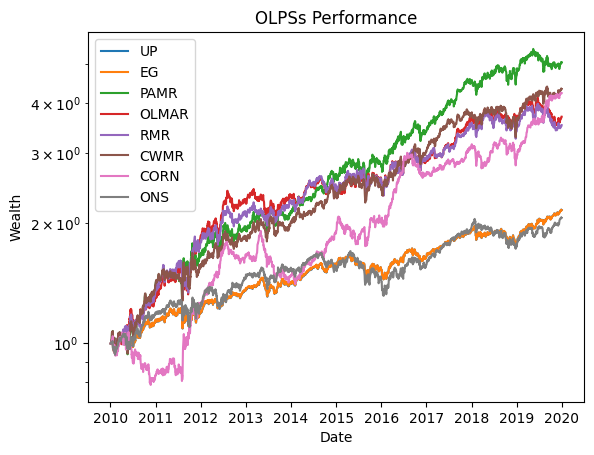

In [ ]:
from universal.algos import BAH, CRP, BCRP, DynamicCRP, UP, EG, Anticor, PAMR, OLMAR, RMR, CWMR, WMAMR, RPRT, BNN, CORN, BestMarkowitz, Kelly, BestSoFar, ONS
from universal.result import ListResult

olpss = [UP(), EG(), PAMR(), OLMAR(), RMR(), CWMR(), CORN(), ONS()]
results = []
for algo in olpss:
    try:
        results.append(algo.run(S))
    except Exception as e:
        print(f"Could not run {algo.__class__.__name__}: {e}")
df = ListResult(results, [algo.__class__.__name__ for algo in olpss]).to_dataframe()
train_df = df.reset_index(drop=False)
train_df = train_df[train_df['Date'] < train_cutoff]
for algo in olpss:
    if algo.__class__.__name__ in train_df.columns:       
        plt.plot(train_df['Date'], train_df[algo.__class__.__name__], label=algo.__class__.__name__)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Wealth')
plt.yscale('log')
plt.title('OLPSs Performance')

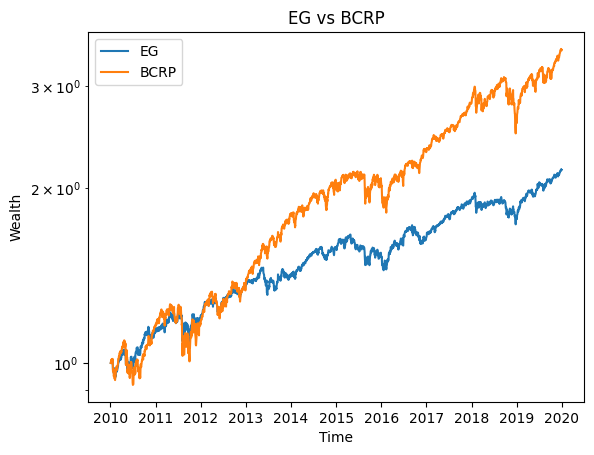

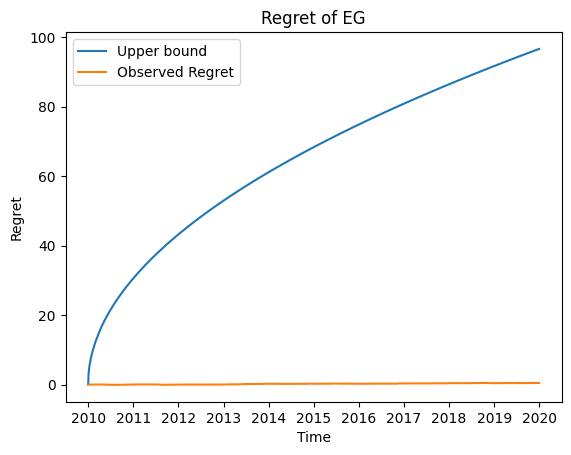

In [48]:
def plot_regret(algo, regret_fn=None):
    algo_name = algo.__class__.__name__
    algo_result = ListResult([algo.run(S1)], [algo_name]).to_dataframe() # df with date as axis and algo as column representing wealth at time t
    bcrp_result = ListResult([BCRP().run(S1)], ['BCRP']).to_dataframe() # df with date as axis and bcrp as column representing wealth at time t

    result = pd.concat([algo_result, bcrp_result], axis=1)

    plt.plot(result[algo_name], label=algo_name)
    plt.plot(result['BCRP'], label='BCRP')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Wealth')
    plt.yscale('log')
    plt.title(f'{algo_name} vs BCRP')
    plt.show()

    result['regret'] = np.log(result['BCRP']) - np.log(result[algo_name])
    
    if regret_fn is not None:
        T = ((dt.datetime(2020, 1, 1) - dt.timedelta(days=1)) - start_date).days
        ts = np.linspace(0, T, 1000)
        x = [start_date + dt.timedelta(days=int(t)) for t in ts]
        y = regret_fn(ts)
        
        plt.plot(x, y, label='Upper bound')
    
    plt.plot(result['regret'], label='Observed Regret')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Regret')
    plt.title(f'Regret of {algo_name}')
    plt.show()

S1 = S.reset_index(drop=False)
S1 = S1[S1['Date'] < train_cutoff].set_index('Date')
c = (S1 / S1.shift(1)).min().min()
C = (S1 / S1.shift(1)).max().max()
    
plot_regret(EG(), lambda t: (C / c) * np.sqrt(t * np.log(len(stocks))))

In [49]:
degrees = 5

data = [S]

for degree in range(degrees):
    results = []
    for algo in olpss:
        try:
            df = ListResult([algo.run(data[-1])], [algo.__class__.__name__]).to_dataframe()
            results.append(df)
        except:
            print(f'Failed to run {algo.__class__.__name__} at degree {degree}')
            results.append(data[-1][[algo.__class__.__name__]])
    df = pd.concat(results, axis=1)
    data.append(df)

Failed to run CWMR at degree 4


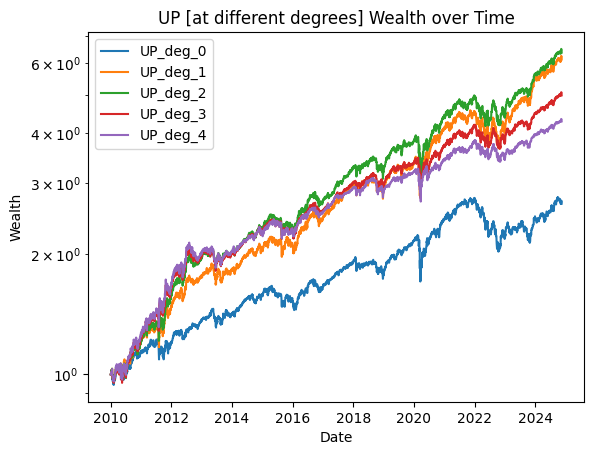

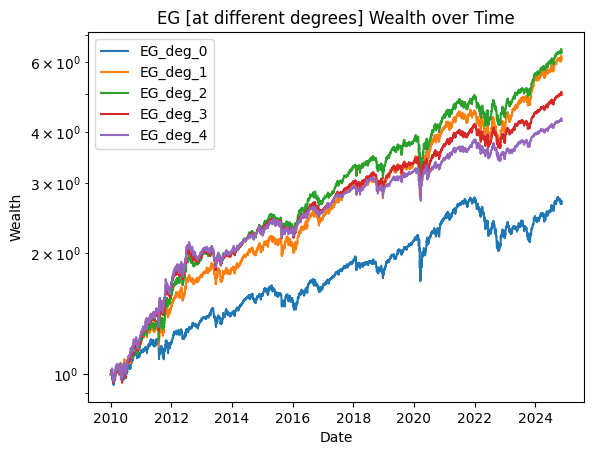

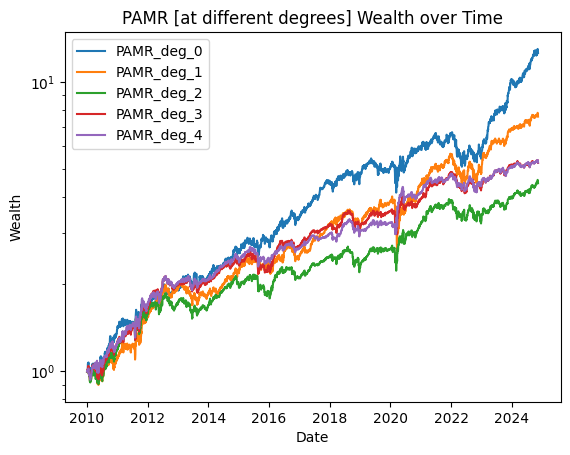

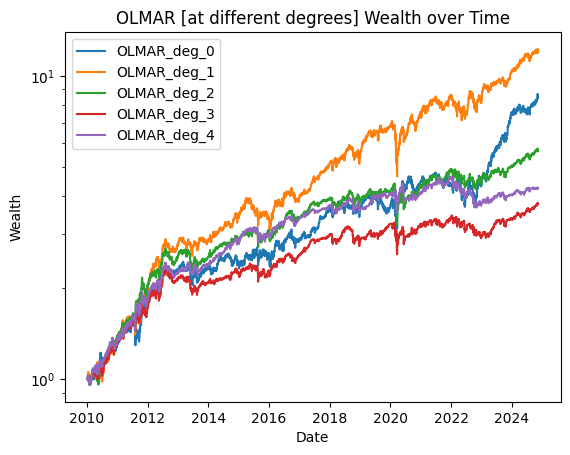

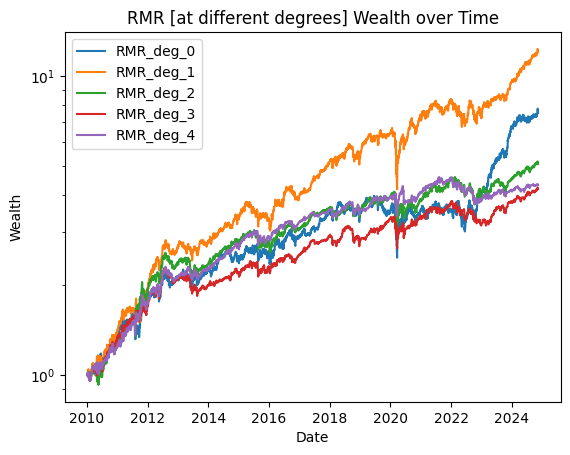

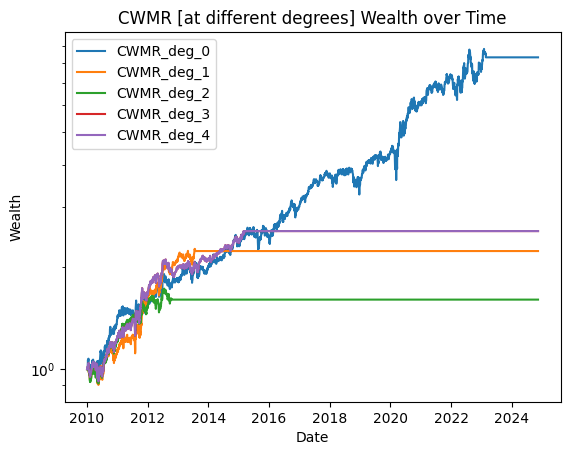

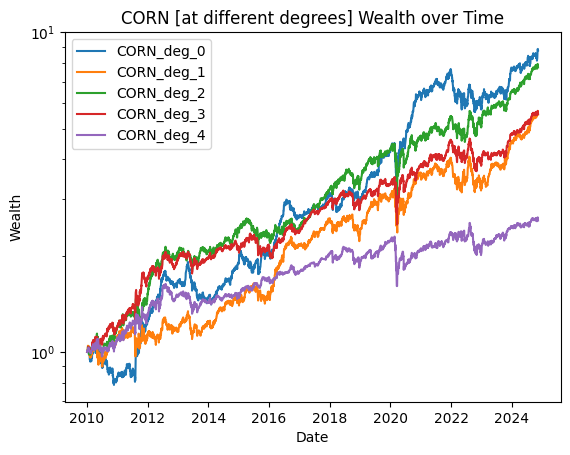

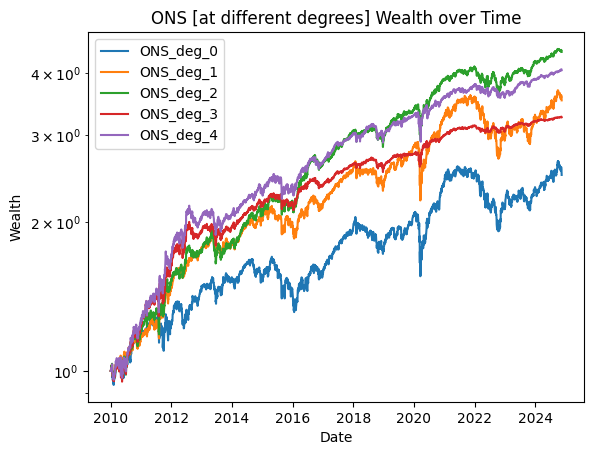

In [54]:
for algo in olpss:
    returns = [
        data[i + 1][[algo.__class__.__name__]].rename(columns={algo.__class__.__name__: f'{algo.__class__.__name__}_deg_{i}'}) for i in range(degrees)
    ]
    returns = pd.concat(returns, axis=1)
    
    for i in range(degrees):
        plt.plot(returns[f'{algo.__class__.__name__}_deg_{i}'], label=f'{algo.__class__.__name__}_deg_{i}')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Wealth')
    plt.yscale('log')
    # plt.ylim(0, 160)
    plt.title(f"{algo.__class__.__name__} [at different degrees] Wealth over Time")
    plt.show()

In [51]:
degrees = 5

data1 = [S]
olftws = set(['UP', 'EG', 'ONS'])

for degree in range(degrees):
    results = []
    for algo in olpss:
        if algo.__class__.__name__ in olftws or degree <= 1:
            try:
                df = ListResult([algo.run(data1[-1])], [algo.__class__.__name__]).to_dataframe()
                results.append(df)
            except:
                print(f'Failed to run {algo.__class__.__name__} at degree {degree}')
                results.append(data1[-1][[algo.__class__.__name__]])
        else:
            results.append(data1[-1][[algo.__class__.__name__]])
    df = pd.concat(results, axis=1)
    data1.append(df)

Failed to run CWMR at degree 1


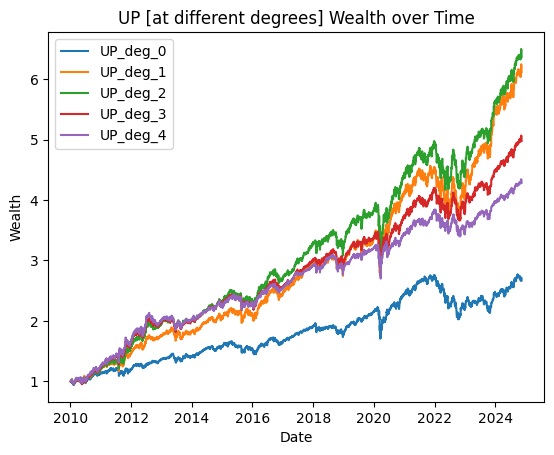

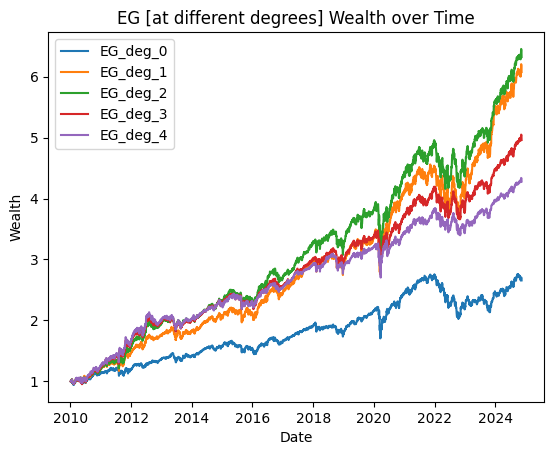

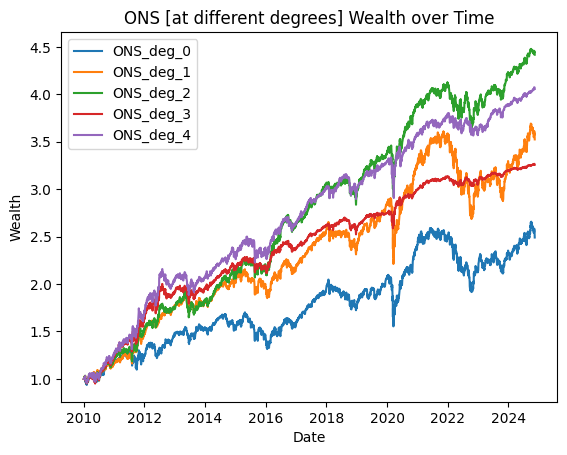

In [52]:
for algo in olpss:
    if algo.__class__.__name__ in olftws:
        returns = [
            data[i + 1][[algo.__class__.__name__]].rename(columns={algo.__class__.__name__: f'{algo.__class__.__name__}_deg_{i}'}) for i in range(degrees)
        ]
        returns = pd.concat(returns, axis=1)
        
        for i in range(degrees):
            plt.plot(returns[f'{algo.__class__.__name__}_deg_{i}'], label=f'{algo.__class__.__name__}_deg_{i}')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel('Wealth')
        plt.title(f"{algo.__class__.__name__} [at different degrees] Wealth over Time")
        plt.show()